This notebook assumes access to detrended, denoised signals and calculates various parameters (and uncertainties) from these signals and serves as an area for experimentation with methods for parameter estimation. The parameters estimated within this notebook are split into three different types: time-domain, frequency-domain and non-linear:

Time domain:
 - mean RR intervals
 - std RR intervals 
 - mean amplitude
 - RMSSD of differences between successive RR intervals 
 - pNN50 (%) NN50 divided by total number of RR (NN50 is the number of sucessive RR intervals that differ by more than 50ms) 
 - signal moments
 
 
Frequency Domain:
- absolute power of LF (0.04 - 0.15 Hz) band
- absolute power of HF (0.15 to 0.4Hz) band
- LF/HF ratio
- Total power (0-0.4 Hz)

Non-linear:
- Fractal dimension of dynamic attractor of signal
- std of poincare
- Shannon entropy
- recurrence rate
- detrended fluctuation analysis
- correlation dimension
- sample entropy


In [1]:
%run "Data_PreProcessing.ipynb" #allowing access to the filtered database with preprocessed signals

100%|████████████████████████████████████████████████████████████████████████████████| 202/202 [00:02<00:00, 87.90it/s]


In [2]:
from scipy.signal import find_peaks, correlate

In [3]:
test_indice = -6#set test signal to be used throughout notebook #219 is healthy
test_signal = denoised_signals[test_indice] 

In [4]:
def parameter_averages(parameter, health_state):
    """
    calculates healthy and unhealthy means and std of parameter for easy comparisson
    returns np.array containing: healthy mean, healthy std, unhealthy mean, unhealhty std
    """
    encoded_health_state = [True if label == 'Unhealthy' else False for label in health_state]
    
    unhealthy_param = parameter[encoded_health_state]
    healthy_param = parameter[~np.array(encoded_health_state)]
    
    unhealthy_param_av = np.mean(unhealthy_param)
    unhealthy_param_std = np.std(unhealthy_param)
    
    healthy_param_av = np.mean(healthy_param)
    healthy_param_std = np.std(healthy_param)
    
    return np.array([healthy_param_av, healthy_param_std, unhealthy_param_av, unhealthy_param_std])

def print_averages(parameter, parameter_name):
    health_state = allowed_patients.get_diagnoses()
    
    means = parameter_averages(parameter, health_state)
    
    print(f"Unhealthy {parameter_name}: mean:{means[2]}, std: {means[3]}")
    print(f"Healthy {parameter_name}: mean:{means[0]}, std:{means[1]}")
    return None

def remove_outliers_z_score(data, threshold=2):
    mean = np.mean(data)
    std = np.std(data)
    z_scores = [(x - mean) / std for x in data]
    filtered_data = [x for x, z in zip(data, z_scores) if abs(z) < threshold]
    return filtered_data

def get_rri(signal, remove_outliers=False):
    peaks, _ = find_peaks(signal, distance = 600)
    peak_to_peaks = peaks[1:-1]

    # calculates rr intervals
    rri = np.diff(peak_to_peaks)
    
    #attempting removal of outliers
    if remove_outliers:
        rri = remove_outliers_z_score(rri)
    
    return rri
    

    

## Time Domain

### Peak to Peak times and Peak amplitude (R)

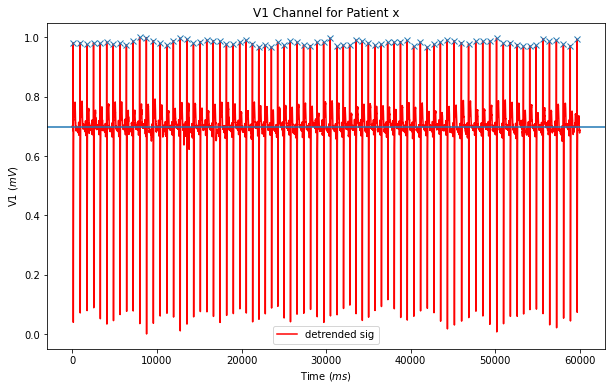

In [5]:
peaks, _ = find_peaks(test_signal, distance=500) #can add height but still dont know how to do exactly

fig, ax = plt.subplots(1, 1, figsize = (10, 6))

ax.plot(test_signal, color = 'red', label = 'detrended sig')
ax.plot(peaks, test_signal[peaks], 'x')
ax.axhline(np.median(test_signal))

ax.set_xlabel(r'Time ($ms$)')
ax.set_ylabel(r'V1 ($mV$)')
ax.set_title('V1 Channel for Patient x')

ax.legend()
plt.show()

identified peaks, should get rid of first and last values in it, wont hurt much even if is correct ones. I shall now implement a function to perform this for all signals in the database, may have to find a way to automatically calculate the distance between signals, find way to get rid of outliers....
- remove outliers - no because want to keep the arythmic activity!
- remove first and last values?
- dont investigate R-amplitude??

R–R intervals differing more than 20% of the mean R–R interval were removed. A linear interpolation was used in order to replace the removed beats. On the other hand, the R–R series with R–R exclusion greater than 20% were excluded from the analysis. - Spectral analysis of heart rate variability with the autoregressive method: What model order to choose?

In [6]:
#why do some signals have really large tails and some have larger peaks?

In [7]:
def RR_analysis(signal, remove_outliers=False):
    peak_distances = get_rri(signal, remove_outliers)
    
    # stastitical analysis on rr intervals
    mean_RR = np.mean(peak_distances)
    std_RR = np.std(peak_distances)
    
#     #calculating amplitude of R peak
#     peak_amp = signal[peak_to_peaks] - np.median(signal)
#     peak_amp_av = np.mean(peak_amp)
#     peak_amp_std = np.std(peak_amp)

    #RMSSD
    # computes differences between successive RR intervals for RMSSD
    diff_RR_intervals = np.diff(peak_distances)
    
    RMSSD_RR = np.sqrt(np.mean(diff_RR_intervals**2))
    
    #pNN50
    # the number of successive RR intervals that differ by more than 50 ms 
    NN50 = np.sum(np.abs(diff_RR_intervals) > 50)
    # divide by total number of RR intervals
    pNN50 = (NN50 / len(peak_distances)) * 100
    
    return mean_RR, std_RR, RMSSD_RR, pNN50


rr_means = np.zeros(shape = no_patients)
rr_stds = np.zeros(shape = no_patients)
rr_RMSSD = np.zeros(shape = no_patients)
rr_pNN50s = np.zeros(shape = no_patients)
for i, signal in enumerate(denoised_signals):
    rr_mean, rr_std, rr_rmssd, rr_pNN50 = RR_analysis(signal, remove_outliers=True)
    rr_means[i] = rr_mean
    rr_stds[i] = rr_std
    rr_RMSSD[i] = rr_rmssd
    rr_pNN50s[i] = rr_pNN50


In [8]:
print_averages(rr_means, 'RR means')
print_averages(rr_stds, 'RR stds')
print_averages(rr_RMSSD, 'RMSSDs')
print_averages(rr_pNN50s, 'pNN50s')

Unhealthy RR means: mean:822.8644116379099, std: 128.98681114993704
Healthy RR means: mean:883.7147868508177, std:118.44690355865836
Unhealthy RR stds: mean:53.09766310551769, std: 64.61869582413448
Healthy RR stds: mean:51.62271515498987, std:60.4705388940473
Unhealthy RMSSDs: mean:66.43398289234082, std: 85.80280618766423
Healthy RMSSDs: mean:54.18199301903112, std:74.52808029225164
Unhealthy pNN50s: mean:18.80654939845452, std: 25.93713414025078
Healthy pNN50s: mean:16.329689315103657, std:21.24888815317756


The above suggest that in the case of the R-R time the means are different however the standard deviations are similar, however the opposite is the case for the amplitudes.

In [9]:
from scipy.stats import skew, kurtosis

def get_moments(signal):
    mean = np.mean(signal)
    std = np.std(signal)
    skew_ecg = skew(signal)
    kurtosis_ecg = kurtosis(signal)
    return mean, std, skew_ecg, kurtosis_ecg

means = np.zeros(shape = no_patients)
stds = np.zeros(shape = no_patients)
skews = np.zeros(shape = no_patients)
kurtosiss = np.zeros(shape = no_patients)
for i, signal in enumerate(denoised_signals):
    mean, std, ecg_skew, ecg_kurtosis = get_moments(signal)
    means[i] = mean
    stds[i] = std
    skews[i] = ecg_skew
    kurtosiss[i] = ecg_kurtosis
    
    

In [10]:
print_averages(means, 'means')
print_averages(stds, 'stds')
print_averages(skews, 'skews')
print_averages(kurtosiss, "kurtosis'")

Unhealthy means: mean:0.7000834414206538, std: 0.168756971340529
Healthy means: mean:0.7444328822393981, std:0.08450232245938545
Unhealthy stds: mean:0.13048234847653484, std: 0.029779397964158988
Healthy stds: mean:0.1146917239140083, std:0.020223981769336274
Unhealthy skews: mean:-2.568661876917792, std: 2.073008782200359
Healthy skews: mean:-3.716154120700621, std:0.8585484240202387
Unhealthy kurtosis': mean:13.540602387683107, std: 6.836449497303079
Healthy kurtosis': mean:18.74178303888289, std:5.851447527123128


## Frequency Domain

### Power Bands

In [11]:
from scipy.signal import welch
from scipy.interpolate import interp1d

fs = 1000 #Hz
fs_interpolate = 3 #Hz

peaks, _ = find_peaks(test_signal, distance=600)
rr_intervals = np.diff(peaks)/fs # RR intervals in seconds, fs is the sampling frequency of the original signal
    
# Time points of the RR intervals
rr_times = np.cumsum(rr_intervals)
rr_times = np.insert(rr_times, 0, 0)  # Add time zero at the beginning

# Interpolation
interpolated_time = np.arange(0, rr_times[-2], 1/fs_interpolate)  # Interpolated time vector

interpolated_rr = interp1d(rr_times[:-1], rr_intervals, kind='cubic')(interpolated_time)

f, psd = welch(interpolated_rr, fs=fs_interpolate, nperseg=128)

print(f)
print(psd)

# Define frequency bands
lf_band = (0.04, 0.15)
hf_band = (0.15, 0.40)

# Integrate the power spectral density over the frequency bands
lf_power = np.trapz(psd[(f >= lf_band[0]) & (f <= lf_band[1])], f[(f >= lf_band[0]) & (f <= lf_band[1])])
hf_power = np.trapz(psd[(f >= hf_band[0]) & (f <= hf_band[1])], f[(f >= hf_band[0]) & (f <= hf_band[1])])

[0.        0.0234375 0.046875  0.0703125 0.09375   0.1171875 0.140625
 0.1640625 0.1875    0.2109375 0.234375  0.2578125 0.28125   0.3046875
 0.328125  0.3515625 0.375     0.3984375 0.421875  0.4453125 0.46875
 0.4921875 0.515625  0.5390625 0.5625    0.5859375 0.609375  0.6328125
 0.65625   0.6796875 0.703125  0.7265625 0.75      0.7734375 0.796875
 0.8203125 0.84375   0.8671875 0.890625  0.9140625 0.9375    0.9609375
 0.984375  1.0078125 1.03125   1.0546875 1.078125  1.1015625 1.125
 1.1484375 1.171875  1.1953125 1.21875   1.2421875 1.265625  1.2890625
 1.3125    1.3359375 1.359375  1.3828125 1.40625   1.4296875 1.453125
 1.4765625 1.5      ]
[4.82415107e-04 3.06470909e-03 2.81273766e-03 4.33412078e-03
 3.53536006e-03 2.24278066e-03 2.68033045e-04 3.10621525e-05
 8.16682401e-06 4.05019074e-04 9.80895646e-04 2.66442863e-04
 3.23148527e-05 8.90136105e-06 1.51526245e-05 4.77576918e-05
 1.03245531e-05 7.08477221e-06 1.21606292e-05 3.01988191e-05
 8.50677482e-05 1.39100482e-05 1.49911274e-

In [12]:
print(lf_power, hf_power)
print(lf_power/hf_power) #should be about 2 if healthy

0.0002731089106859076 4.20480223201398e-05
6.495166612273611


In [13]:
def power_bands(signal):
    fs = 1000 #Hz
    fs_interpolate = 3 #Hz
    
    # define frequency bands
    lf_band = (0.04, 0.15)
    hf_band = (0.15, 0.40)
    
    peaks, _ = find_peaks(signal, distance=600)
    rr_intervals = np.diff(peaks)/fs # RR intervals in seconds, fs is the sampling frequency of the original signal
    
    # time points of the RR intervals
    rr_times = np.cumsum(rr_intervals)
    rr_times = np.insert(rr_times, 0, 0)  # add time zero at the beginning

    # Interpolation
    interpolated_time = np.arange(0, rr_times[-2], 1/fs_interpolate)  # Interpolated time vector
    interpolated_rr = interp1d(rr_times[:-1], rr_intervals, kind='cubic')(interpolated_time)

    #welch spectrum
    f, psd = welch(interpolated_rr, fs=fs_interpolate, nperseg=128)
    
    # Integrate the power spectral density over the frequency bands
    lf_power = np.trapz(psd[(f >= lf_band[0]) & (f <= lf_band[1])], f[(f >= lf_band[0]) & (f <= lf_band[1])])
    hf_power = np.trapz(psd[(f >= hf_band[0]) & (f <= hf_band[1])], f[(f >= hf_band[0]) & (f <= hf_band[1])])
    
    return lf_power, hf_power, lf_power/hf_power
    

In [14]:
lfs = np.zeros(shape = no_patients)
hfs = np.zeros(shape = no_patients)
ratios = np.zeros(shape = no_patients)
for i, signal in enumerate(denoised_signals):
    lf, hf, ratio = power_bands(signal)
    lfs[i] = lf
    hfs[i] = hf
    ratios[i] = ratio

In [15]:
print_averages(lfs, 'lf_power')
print_averages(hfs, 'hf_power')
print_averages(ratios, 'ratio of power bands')

Unhealthy lf_power: mean:0.002246771347577131, std: 0.005716348092590171
Healthy lf_power: mean:0.001986485016994376, std:0.004750847001099235
Unhealthy hf_power: mean:0.004085063574954664, std: 0.00801349983605936
Healthy hf_power: mean:0.0029768474608233256, std:0.006931241434845449
Unhealthy ratio of power bands: mean:2.1906510706529017, std: 4.5578331544128385
Healthy ratio of power bands: mean:3.6707058173199845, std:6.545749052455982


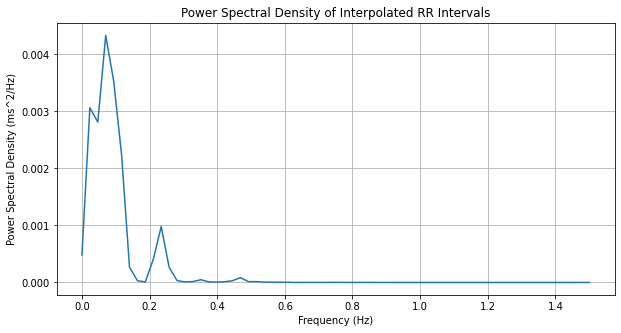

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(f, psd)
plt.title('Power Spectral Density of Interpolated RR Intervals')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (ms^2/Hz)')
plt.grid()
plt.show()

### DWT


In [17]:
def single_DWT(signal, wavelet='db4'):
    coeffs = pywt.dwt(signal, wavelet)
    mean = np.zeros(shape=len(coeffs))
    std = np.zeros(shape=len(coeffs))
    coeff_min = np.zeros(shape=len(coeffs))
    coeff_max = np.zeros(shape=len(coeffs))
    for i, coeff in enumerate(coeffs):
        mean[i] = np.mean(coeff)
        std[i] = np.std(coeff)
        coeff_min[i] = np.min(coeff)
        coeff_max[i] = np.max(coeff)
    return mean, std, coeff_min, coeff_max
    

In [18]:
DWT_means = np.zeros(shape = (no_patients, 2))
DWT_stds = np.zeros(shape = (no_patients, 2))
DWT_mins = np.zeros(shape = (no_patients, 2))
DWT_maxs = np.zeros(shape = (no_patients, 2))
for i, signal in enumerate(denoised_signals):
    DWT_mean, DWT_std, DWT_min, DWT_max = single_DWT(signal)
    DWT_means[i] = DWT_mean 
    DWT_stds[i] = DWT_std
    DWT_mins[i] = DWT_min
    DWT_maxs[i] = DWT_max

In [19]:
print_averages(DWT_means[:, 0], 'mean approx coeff')
print('---')
print_averages(DWT_means[:, 1], 'mean detail coeff')
print('---')
print_averages(DWT_stds[:, 0], 'std approx coeff')
print('---')
print_averages(DWT_stds[:, 1], 'std detail coeff')
print('---')
print_averages(DWT_mins[:, 0], 'min approx coeff')
print('---')
print_averages(DWT_mins[:, 1], 'min detail coeff')
print('---')
print_averages(DWT_maxs[:, 0], 'max approx coeff')
print('---')
print_averages(DWT_maxs[:, 1], 'max detail coeff')

Unhealthy mean approx coeff: mean:0.9900670353655874, std: 0.23865925119323483
Healthy mean approx coeff: mean:1.0527876452926817, std:0.11950320541624149
---
Unhealthy mean detail coeff: mean:-1.7539678082246404e-10, std: 2.640896924912448e-09
Healthy mean detail coeff: mean:1.5233693717357064e-10, std:8.69899113055772e-10
---
Unhealthy std approx coeff: mean:0.18452305804326719, std: 0.042112147784081934
Healthy std approx coeff: mean:0.16219161684707945, std:0.0285991638196516
---
Unhealthy std detail coeff: mean:2.033265711679346e-05, std: 1.0063505780939901e-05
Healthy std detail coeff: mean:2.189005089729486e-05, std:8.126992171044343e-06
---
Unhealthy min approx coeff: mean:0.0006725813549430037, std: 0.0010286412225755505
Healthy min approx coeff: mean:0.0009636860011270944, std:0.0014605968871410381
---
Unhealthy min detail coeff: mean:-0.00034799762907091315, std: 0.00047540165634731897
Healthy min detail coeff: mean:-0.00022730078747872431, std:0.00019906598798903713
---
Unh

In [20]:
def multi_DWT(signal, level, wavelet='db4'):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    
    mean = np.zeros(shape=len(coeffs))
    std = np.zeros(shape=len(coeffs))
    coeff_min = np.zeros(shape=len(coeffs))
    coeff_max = np.zeros(shape=len(coeffs))
    for i, coeff in enumerate(coeffs):
        mean[i] = np.mean(coeff)
        std[i] = np.std(coeff)
        coeff_min[i] = np.min(coeff)
        coeff_max[i] = np.max(coeff)
    return mean, std, coeff_min, coeff_max
    
level = 8
    
multi_DWT_means = np.zeros(shape = (no_patients, level+1))
multi_DWT_stds = np.zeros(shape = (no_patients, level+1))
multi_DWT_mins = np.zeros(shape = (no_patients, level+1))
multi_DWT_maxs = np.zeros(shape = (no_patients, level+1))
for i, signal in enumerate(denoised_signals):
    multi_DWT_mean, multi_DWT_std, multi_DWT_min, multi_DWT_max = multi_DWT(signal, level)
    multi_DWT_means[i] = multi_DWT_mean 
    multi_DWT_stds[i] = multi_DWT_std
    multi_DWT_mins[i] = multi_DWT_min
    multi_DWT_maxs[i] = multi_DWT_max



In [21]:
for i in range(0, multi_DWT_means.shape[1]):
    print_averages(multi_DWT_means[:, i], f'mean approx coeff {i}')
    print('---')
    

Unhealthy mean approx coeff 0: mean:11.19991475241406, std: 2.7020569085817154
Healthy mean approx coeff 0: mean:11.912028339832446, std:1.349662184799116
---
Unhealthy mean approx coeff 1: mean:0.0017783383678362408, std: 0.056752987957026095
Healthy mean approx coeff 1: mean:0.006654322400219509, std:0.04426562115630596
---
Unhealthy mean approx coeff 2: mean:0.00037944600082039624, std: 0.026059420062867683
Healthy mean approx coeff 2: mean:4.831659088984635e-05, std:0.024603810565042145
---
Unhealthy mean approx coeff 3: mean:0.001152155328044934, std: 0.013763946035856955
Healthy mean approx coeff 3: mean:9.620625695276643e-05, std:0.012960145220872372
---
Unhealthy mean approx coeff 4: mean:-1.8617441212470677e-05, std: 0.0018578109965118946
Healthy mean approx coeff 4: mean:-0.0002846045065801403, std:0.002934107602560745
---
Unhealthy mean approx coeff 5: mean:-4.709925567017453e-07, std: 3.184244748380576e-05
Healthy mean approx coeff 5: mean:-1.4882011117754674e-05, std:3.850

## Non-Linear Domain

### Standard deviation of Poincare Plot
plot of each rr interval against the next, essentially a phase plot

In [22]:
#attempting removal of outliers
def remove_outliers_z_score(data, threshold=3):
    mean = np.mean(data)
    std = np.std(data)
    z_scores = [(x - mean) / std for x in data]
    filtered_data = [x for x, z in zip(data, z_scores) if abs(z) < threshold]
    return filtered_data

def plot_poincare(rr_intervals, compare=False):
    x = rr_intervals[:-1]
    y = rr_intervals[1:]
    
    if compare:
        removed_outliers = remove_outliers_z_score(rr_intervals)
        filtx = removed_outliers[:-1]
        filty = removed_outliers[1:]
        diff = len(rr_intervals) - len(removed_outliers)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))
        ax2.scatter(filtx, filty, s=10, alpha=0.5)
        ax2.plot(filtx, filtx, color='red', linestyle='--')  # Line of identity (y = x)
        ax2.set_title(f'Poincaré Plot, Removed {diff} samples')
        ax2.set_xlabel('RR_n (ms)')
        ax2.set_ylabel('RR_{n+1} (ms)')
        ax2.grid()
        
    else:
        fig, ax1 = plt.subplots()

    ax1.scatter(x, y, s=10, alpha=0.5)
    ax1.plot(x, x, color='red', linestyle='--')  # Line of identity (y = x)
    ax1.set_title('Poincaré Plot')
    ax1.set_xlabel('RR_n (ms)')
    ax1.set_ylabel('RR_{n+1} (ms)')
    ax1.grid(True)
    ax1.axis('equal')  # Ensure aspect ratio is equal
    plt.show()
    return None
    
def calculate_poincare_sd(sig, remove_outliers=False):
    #get rr intervals
    rr_intervals = get_rri(sig)
    
    if remove_outliers:
        rr_intervals = remove_outliers_z_score(rr_intervals)
        
    #separating into subsequent coordinates for Poincaré plot
    rr_n = rr_intervals[:-1]
    rr_n1 = rr_intervals[1:]
    
    #calculating SD1, perpendicular to y=x
    diff_rr = np.array(rr_n) - np.array(rr_n1)
    sd1 = np.sqrt(np.var(diff_rr/np.sqrt(2)))
    
    # calculating SD2, along y=x
    sum_rr = rr_n + rr_n1
    sd2 = np.sqrt(np.var(sum_rr/np.sqrt(2)))
   
    return sd1, sd2

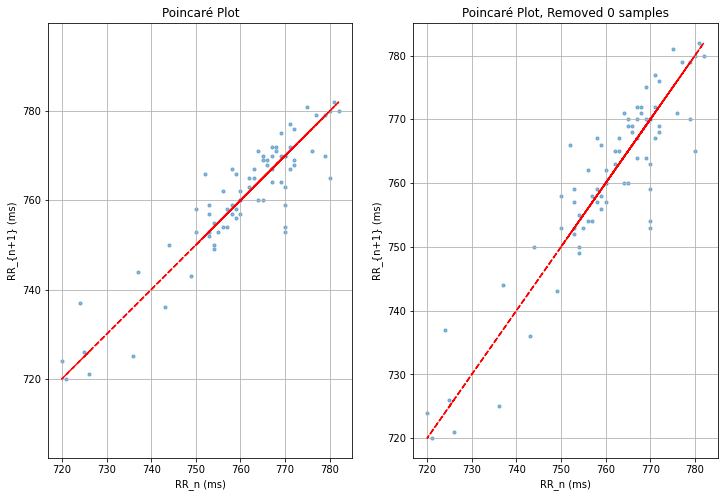

In [23]:
rr_intervals = get_rri(signals[99])
plot_poincare(rr_intervals, compare = True)

In [24]:
sd1, sd2 = calculate_poincare_sd(signal)
print(sd1, sd2)

18.189534214200688 26.04383026785478


In [25]:
sd1s = np.zeros(shape = no_patients)
sd2s = np.zeros(shape = no_patients)
for i, signal in enumerate(denoised_signals):
    sd1, sd2 = calculate_poincare_sd(signal)
    sd1s[i] = sd1
    sd2s[i] = sd2

In [26]:
print_averages(sd1s, 'sd1s')
print_averages(sd2s, 'sd2s')

Unhealthy sd1s: mean:60.09697341677985, std: 66.26802368597359
Healthy sd1s: mean:46.03830079280871, std:53.657838703522025
Unhealthy sd2s: mean:73.82450125630487, std: 75.00148552996087
Healthy sd2s: mean:74.14020658158967, std:69.12466494546108


In [27]:
#with outliers removed
sd1s = np.zeros(shape = no_patients)
sd2s = np.zeros(shape = no_patients)
for i, signal in enumerate(denoised_signals):
    sd1, sd2 = calculate_poincare_sd(signal, remove_outliers=True)
    sd1s[i] = sd1
    sd2s[i] = sd2

In [28]:
print_averages(sd1s, 'sd1s')
print_averages(sd2s, 'sd2s')

Unhealthy sd1s: mean:55.359148183829674, std: 66.25129154613514
Healthy sd1s: mean:41.69830512296622, std:53.344052080678615
Unhealthy sd2s: mean:44.66468910788897, std: 49.22941094689731
Healthy sd2s: mean:40.70499583751618, std:42.61620567216911


### Sample Entropy
quantifies the unpredictability of fluctuations in the data set

In [29]:
def calculate_sample_entropy(signal, m=2, r=0.2):
    rr_intervals = get_rri(signal)
    N = len(rr_intervals)
    r *= np.std(rr_intervals)  # tolerance r is usually set as a fraction of the standard deviation
    
    def _phi(m):
        X = np.array([rr_intervals[i:i + m] for i in range(N - m + 1)])
        C = np.sum(np.max(np.abs(X[:, None] - X[None, :]), axis=2) <= r, axis=0) - 1
        return np.sum(C) / (N - m + 1)
    return -np.log(_phi(m + 1) / _phi(m))

In [30]:
samp_en = calculate_sample_entropy(signal)
print("Sample Entropy:", samp_en)

Sample Entropy: 0.6350433116331533


In [31]:

samp_ens = np.zeros(shape = no_patients)
for i, signal in enumerate(denoised_signals):
    samp_en = calculate_sample_entropy(signal)
    samp_ens[i] = samp_en

<ipython-input-29-2d6f5be5d116>:10: RuntimeWarning: divide by zero encountered in log
  return -np.log(_phi(m + 1) / _phi(m))


In [32]:
print_averages(samp_ens, 'sample entropy') #fix this!!!

Unhealthy sample entropy: mean:inf, std: nan
Healthy sample entropy: mean:1.4285068922591924, std:0.5728840755268262


C:\Users\court\Documents\anaconda\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


### Shannon Entropy 
also known as information entropy, is a measure of the uncertainty or randomness in a set of values

In [33]:
def calculate_shannon_entropy(rr_intervals, num_bins=10):
    # discretize RR intervals into bins and calculate probabilities
    hist, bin_edges = np.histogram(rr_intervals, bins=num_bins, density=True)
    
    probabilities = hist / np.sum(hist)
    
    # Calculate Shannon Entropy using equation
    shannon_entropy = -np.sum(probabilities * np.log2(probabilities + 1e-12))  # adding a small value to avoid log(0)
    
    return shannon_entropy

In [34]:
shannon_en = calculate_shannon_entropy(rr_intervals)
print('Shannon Entropy:', shannon_en)

Shannon Entropy: 2.8502127467851963


In [35]:
shannon_ens = np.zeros(shape = no_patients)
for i, signal in enumerate(denoised_signals):
    shannon_en = calculate_shannon_entropy(signal)
    shannon_ens[i] = shannon_en

In [36]:
print_averages(shannon_ens, 'shannon entropy')

Unhealthy shannon entropy: mean:1.5441373326971484, std: 0.3718141786784633
Healthy shannon entropy: mean:1.3297251147464324, std:0.3306809045323388


### Correlation Dimension

experimented with a couple of methods but all lead to memory issues.

In [37]:
#calculating autocorrelation and time delay
def autocorrelation(signal):
    n = len(signal)
    mean = np.mean(signal)
    var = np.var(signal)
    signal = signal - mean
    autocorr = correlate(signal, signal, mode='full')[n-1:] / (var * n) #scipy correlate alottttt faster
    return autocorr

def find_time_delay(signal):
    autocorr = autocorrelation(signal)
    # Find the point where autocorrelation drops to 1/e of its initial value
    threshold = 1 / np.exp(1)
    tau = np.argmax(autocorr <= threshold) #measured in units of sampling rate (1000 hz)
    return tau


In [38]:
#this takes foreverrrrrr - fixed using scipy.correlate
tau = np.zeros(shape = no_patients, dtype=int)
for i in tqdm(range(0, no_patients)):
    tau[i] = find_time_delay(denoised_signals[i])

100%|███████████████████████████████████████████████████████████████████████████████| 202/202 [00:01<00:00, 115.90it/s]


In [39]:
#original embedding of time series
def embed_time_series(signal, tau, m):
    n = len(signal)
    if n < (m - 1) * tau:
        raise ValueError("Time series is too short for the chosen tau and embedding dimension.")
    embedded = np.array([signal[i : i + (m - 1) * tau + 1 : tau] for i in range(n - (m - 1) * tau)])
    return embedded

#     N = len(signal)
#     M = N - (m - 1) * tau
#     if M <= 0:
#         raise ValueError("Time series too short for given m and tau")
#     phase_space = np.zeros((M, m))
#     for i in range(m):
#         phase_space[:, i] = signal[i * tau : i * tau + M]
#     return phase_space

# embedding dimension M
M = 3

#creates list of embedded arrays i.e. no_patients * len(embedded) * M
embedded_signals = []
for i in tqdm(range(0, no_patients)):
    embedded_signals.append(embed_time_series(denoised_signals[i], tau[i], M))

100%|████████████████████████████████████████████████████████████████████████████████| 202/202 [00:11<00:00, 17.55it/s]


In [40]:
#calculates the pairwise euclidean distances for each reconstructed vector X(i), X(j)

from scipy.spatial.distance import pdist, squareform

print(embedded_signals[2].shape[0])

59880


In [41]:
from scipy.spatial.distance import pdist, squareform

def count_pairs_within_radius(distance_matrix, r):
    N = distance_matrix.shape[0]
    count = np.sum((distance_matrix < r) & (distance_matrix > 0))  # Exclude self-pairs
    return count


r = 0.5 #setting radius with which to check that distances are within
pair_count = np.zeros(shape = no_patients)
for phase_space in embedded_signals:
    #calculates the pairwise euclidean distances for each reconstructed vector X(i), X(j)
    distances = pdist(phase_space, 'euclidean')

    # Convert distances to a square form
    distance_matrix = squareform(distances)
    
    pair_count = count_pairs_within_radius(distance_matrix, r)
    
    

MemoryError: Unable to allocate 13.4 GiB for an array with shape (1795293081,) and data type float64

In [ ]:
from scipy.spatial.distance import euclidean


# using incremental pairwise distance calculation due to memory allocation issues
def count_pairs_within_radius(phase_space, r):
    M = phase_space.shape[0]
    count = 0
    for i in range(M):
        for j in range(i + 1, M):
            if euclidean(phase_space[i], phase_space[j]) < r:
                count += 1
    return count

r = 0.5 #setting radius with which to check that distances are within
pair_count = np.zeros(shape = no_patients)
for i, phase_space in tqdm(enumerate(embedded_signals)):
    pair_count = count_pairs_within_radius(phase_space, r)
    

In [ ]:
import nolds

corr_dimen = nolds.corr_dim(denoised_signals[0], emb_dim=2)

### Detrended Fluctuation Analysis

In [ ]:
import nolds

dfa = nolds.dfa(denoised_signals[0])

In [ ]:
print(dfa)

In [ ]:
#will take a long time!!
dfas = np.zeros(shape = no_patients)
for i, signal in enumerate(denoised_signals):
    dfa = nolds.dfa(signal)
    dfas[i] = dfa

In [ ]:
print_averages(dfas, 'dfas')

### Multi - Fractal Analysis

- use signals to reconstruct dynamical attractors, used to quantify differences in signals
- calculate time delay, point where autocorrelation drops to 1/e
- each time series is then embedded into M dimension
    - M decided at point at which any fractal measure saturates, e.g $D_2$, correlation dimension.
- perform SVD on embedded signal to get embedded attractor
- perform fractal analysis on embedded attractor

In [ ]:
#calculating autocorrelation and time delay
def autocorrelation(signal):
    n = len(signal)
    mean = np.mean(signal)
    var = np.var(signal)
    signal = signal - mean
    autocorr = correlate(signal, signal, mode='full')[n-1:] / (var * n) #scipy correlate alottttt faster
    return autocorr

def find_time_delay(signal):
    autocorr = autocorrelation(signal)
    # Find the point where autocorrelation drops to 1/e of its initial value
    threshold = 1 / np.exp(1)
    tau = np.argmax(autocorr <= threshold) #measured in units of sampling rate (1000 hz)
    return tau



In [ ]:
#this takes foreverrrrrr - fixed using scipy.correlate
tau = np.zeros(shape = no_patients, dtype=int)
for i in tqdm(range(0, no_patients)):
    tau[i] = find_time_delay(denoised_signals[i])

In [ ]:
#print(tau)

In [ ]:
#embedding time series
def embed_time_series(signal, tau, m):
    n = len(signal)
    if n < (m - 1) * tau:
        raise ValueError("Time series is too short for the chosen tau and embedding dimension.")
    embedded = np.array([signal[i : i + (m - 1) * tau + 1 : tau] for i in range(n - (m - 1) * tau)])
    return embedded

# embedding dimension M
M = 5 

#creates list of embedded arrays i.e. no_patients * len(embedded) * M
embedded_signals = []
for i in tqdm(range(0, no_patients)):
    embedded_signals.append(embed_time_series(denoised_signals[i], tau[i], M))

In [ ]:
fig, axes = plt.subplots()

print(embedded_signals[3].shape)
axes.plot(embedded_signals[0])
plt.show()

In [ ]:
# performing SVD

from sklearn.preprocessing import StandardScaler
from numpy.linalg import svd

# Standardize the embedded signal
scaler = StandardScaler()
embedded_signal_std = scaler.fit_transform(embedded_signals[0])

# Perform SVD
U, S, VT = svd(embedded_signal_std, full_matrices=False)

# Get the principal components
PCs = U @ np.diag(S)

In [ ]:
#visualising attractors in 3D
 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Plot the first three principal components
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.plot(PCs[:, 0], PCs[:, 1], PCs[:, 2], lw=0.5)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Embedded Attractor from SVD')

plt.show()

In [ ]:
#in 2D

fig, axes = plt.subplots()

axes.plot(PCs[:, 0], PCs[:, 1])

In [ ]:
#calculating fractal dimension through box counting
def box_counting(data, box_sizes):
    counts = []
    for size in box_sizes:
        count = 0
        # creates grid
        grid = np.ceil(data / size).astype(int)
        #counts unique boxes
        unique_boxes = np.unique(grid, axis=0)
        count = len(unique_boxes)
        counts.append(count)
    return counts

def fractal_dimension(data, box_sizes):
    counts = box_counting(data, box_sizes)
    log_box_sizes = np.log(box_sizes)
    log_counts = np.log(counts)
    
    # Perform linear regression to find the slope of the log-log plot
    coeffs = np.polyfit(log_box_sizes, log_counts, 1)
    return -coeffs[0]  # The fractal dimension is the negative slope

# Define box sizes
box_sizes = np.logspace(-1, 1, num=10)  # Adjust as needed

# Calculate the fractal dimension
fd = fractal_dimension(PCs[:, :3], box_sizes)  # Using the first three principal components

In [ ]:
print(f"Fractal Dimension: {fd}")

In [ ]:
# plotting the log-log plot for the box-counting method
import matplotlib.pyplot as plt

log_box_sizes = np.log(box_sizes)
log_counts = np.log(box_counting(PCs[:, :3], box_sizes))

plt.figure(figsize=(8, 6))
plt.plot(log_box_sizes, log_counts, 'o', label='Data points')
plt.plot(log_box_sizes, np.polyval(np.polyfit(log_box_sizes, log_counts, 1), log_box_sizes),
         label=f'Fit line (slope = {-fd:.2f})')
plt.xlabel('log(Box size)')
plt.ylabel('log(Count)')
plt.legend()
plt.title('Fractal Dimension Estimation using Box-Counting Method')
plt.show()

Code to calculate fractal dimension only for each patient:

In [ ]:
#research this properly before doing this final implementation but this allows calculation of just fractal dimension from all signals
def calc_fractal_dim(signal):
    
    scaler = StandardScaler()
    embedded_signal_std = scaler.fit_transform(signal)

    # performs SVD and obtains principal components
    U, S, VT = svd(embedded_signal_std, full_matrices=False)
    PCs = U @ np.diag(S)
    
    # define box sizes
    box_sizes = np.logspace(-1, 1, num=10)  # research/try this out
    
    # calculate the fractal dimension
    fd = fractal_dimension(PCs[:, :3], box_sizes)  # uses the first three principal components
    return fd

fd = np.zeros(shape = no_patients)

for i in tqdm(range(0, no_patients)):
    fd[i] = calc_fractal_dim(embedded_signals[i])
    


In [ ]:
fd_averages = parameter_averages(fd, health_state)
print(fd_averages)